# Introduction
* This notebook contains an implementation of collaborative filtering from scratch (using only numpy).
* Collaborative filtering is an algorithm for recommendation, used for example to predict a user's rating of a movie. 
* This is done by comparing the most similar users to the desired user, and the ratings they gave the desired movie.
* The data I used for this project is the MovieLens 100k, from GroupLens: https://grouplens.org/datasets/movielens/100k/
* In the full data set there are 100000 ratings by 943 users on 1682 movies, where each user has rated at least 20 movies.
* The data sets ratings_train.csv and ratings_test.csv split the full data into a training set and a test set with exactly 10 ratings per user in the test set.
* Using collborative filtering, I got a mean squared error score on the test data set of 1.04.

### The notebook is divided into the following parts:
* [Part 1: Notebook preparation](#part_1)
* [Part 2: Data exploration](#part_2)
* [Part 3: Data preparation](#part_3)
* [Part 4: Collaborative filtering](#part_4)
* [Part 5: Predict the test data and evaluate the model with MSE](#part_5)

<a id="part_1"></a>
# Part 1: Notebook preparation

In [1]:
# Data processing
import pandas as pd
import numpy as np
from sortedcontainers import SortedList

# Visualization
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
df_train = pd.read_csv('ratings_train.csv', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
df_test = pd.read_csv('ratings_test.csv', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])

<a id="part_2"></a>
# Part 2: Data exploration

In [3]:
display(df_train.head(5))
print(f"Shape: {df_train.shape}")

,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


Shape: (90570, 4)


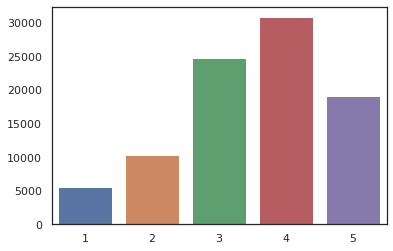

In [4]:
# Rating histogram
sns.barplot(df_train['rating'].value_counts().index, df_train['rating'].value_counts().values)

In [5]:
mostCommonRating = df_train['rating'].value_counts().index[0]

In [6]:
print(f"Unique users in training set: {len(df_train['userId'].unique())}")
print(f"Unique movies in training set: {len(df_train['movieId'].unique())}")
print(f"Total unique movies in training and test set: {len(set(df_train['movieId'].unique()) | set(df_test['movieId'].unique()))}")

Unique users in training set: 943
Unique movies in training set: 1680
Total unique movies in training and test set: 1682


Min ratings per user in training set: 10
Max ratings per user in training set: 727


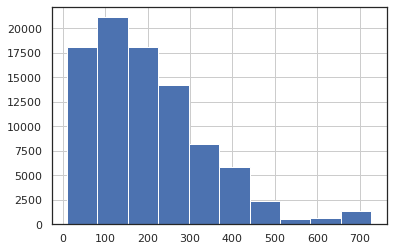

In [7]:
df_train['countPerUser'] = df_train.groupby('userId')['userId'].transform('count')

print(f"Min ratings per user in training set: {df_train['countPerUser'].min()}")
print(f"Max ratings per user in training set: {df_train['countPerUser'].max()}")
df_train['countPerUser'].hist()

In [8]:
display(df_test.head(5))
print(f"Shape: {df_test.shape}")

,userId,movieId,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


Shape: (9430, 4)


<a id="part_3"></a>
# Part 3: Data preparation

* As can be seen in the following test, the mean number of movies that have been rated by each user is higher than the mean number of users that rated each movie.
* In such a case, user-based collaborative filtering is supposed to be better than movie-based collaborative filtering.
* In most cases there are many more users that rated each movie than movies that have been rated by each user, and then movie-based collborative filtering performed better.
* I guess that this data is biased because there are only users that rated at least 20 movies.

In [9]:
userToMovie = {}
movieToUser = {}
userMovieToRating_train = {}
movieUserToRating_train = {}

for user, movie, rating in zip(df_train['userId'], df_train['movieId'], df_train['rating']):
    if user not in userToMovie:
        userToMovie[user] = [movie]
    else:
        userToMovie[user].append(movie)
        
    if movie not in movieToUser:
        movieToUser[movie] = [user]
    else:
        movieToUser[movie].append(user)

    userMovieToRating_train[(user,movie)] = rating
    movieUserToRating_train[(movie,user)] = rating

    
userMovieToRating_test = {}
movieUserToRating_test = {}

for user, movie, rating in zip(df_test['userId'], df_test['movieId'], df_test['rating']):
    userMovieToRating_test[(user,movie)] = rating
    movieUserToRating_test[(movie,user)] = rating

In [10]:
meanUsersPerMovie = np.mean([len(users) for users in movieToUser.values()])
meanMoviesPerUser = np.mean([len(movies) for movies in userToMovie.values()])

print(f"Mean number of users that rated each movie: {round(meanUsersPerMovie,2)}")
print(f"Mean number of movies that have been rated by each user: {round(meanMoviesPerUser,2)}")

Mean number of users that rated each movie: 53.91
Mean number of movies that have been rated by each user: 96.04


<a id="part_4"></a>
# Part 4: Collaborative filtering

In [11]:
def get_neighbors_averages_deviations(userToMovie, userMovieToRating, K, limit):
    """
    Returns dictionaries of neighbors, averages and deviations using collaborative filtering.
    Params:
        userToMovie - dictionary with user as key and list of the movies he rated as value.
        userMovieToRating - dictionary with (user, movie) as key and rating as value.
        K - number of neighbors we'd like to consider.
        limit - number of movies users must have in common in order to be considered neighbors.
    """
    
    neighbors = {} # Store neighbors in this list
    averages = {} # Each item's average rating for later use
    deviations = {} # Each item's deviation for later use
    
    for i in userToMovie.keys():
        # Find the 25 closest users to user i
        movies_i = userToMovie[i]
        movies_i_set = set(movies_i)

        # Calculate avg and deviation
        ratings_i = {movie : userMovieToRating[(i, movie)] for movie in movies_i}
        avg_i = np.mean(list(ratings_i.values()))
        dev_i = {movie : (rating - avg_i) for movie, rating in ratings_i.items()}
        dev_i_values = np.array(list(dev_i.values()))
        sigma_i = np.sqrt(dev_i_values.dot(dev_i_values))

        # Save these for later use
        averages[i] = avg_i
        deviations[i] = dev_i

        sl = SortedList()
        for j in userToMovie.keys():
            # Don't include yourself
            if j != i:
                movies_j = userToMovie[j]
                movies_j_set = set(movies_j)
                common_movies = (movies_i_set & movies_j_set) # intersection
                if len(common_movies) > limit:
                    # Calculate avg and deviation
                    ratings_j = {movie : userMovieToRating[(j, movie)] for movie in movies_j}
                    avg_j = np.mean(list(ratings_j.values()))
                    dev_j = { movie:(rating - avg_j) for movie, rating in ratings_j.items() }
                    dev_j_values = np.array(list(dev_j.values()))
                    sigma_j = np.sqrt(dev_j_values.dot(dev_j_values))

                    # Calculate correlation coefficient
                    numerator = sum(dev_i[m]*dev_j[m] for m in common_movies)
                    w_ij = numerator / (sigma_i * sigma_j)

                    # Insert into sorted list and truncate
                    # negate weight, because list is sorted ascending
                    # maximum value (1) is "closest"
                    sl.add((-w_ij, j))
                    if len(sl) > K:
                        del sl[-1]

        # Store the neighbors
        neighbors[i] = sl
    
    return neighbors, averages, deviations

In [12]:
K = 20 # Number of neighbors we'd like to consider
limit = 5 # Number of movies users must have in common in order to be considered neighbors

# Movie-based collaborative filtering
neighbors_movieBased, averages_movieBased, deviations_movieBased = \
    get_neighbors_averages_deviations(movieToUser, movieUserToRating_train, K, limit)

# User-based collaborative filtering
neighbors_userBased, averages_userBased, deviations_userBased = \
    get_neighbors_averages_deviations(userToMovie, userMovieToRating_train, K, limit)

<a id="part_5"></a>
# Part 5: Predict the test data and evaluate the model with MSE

* As can be seen in the evaluation below, the mean squared error (MSE) is better in the user-based algorithm than in the movie-based.
* This is because each user rated more movies than there were users who rated each movie.

In [13]:
def predict(i, m, neighbors, averages, deviations):
    if i in neighbors:
        # Calculate the weighted sum of deviations
        numerator = 0
        denominator = 0
        for neg_w, j in neighbors[i]:
            # The weight is stored as its negative
            # so the negative of the negative weight is the positive weight
            try:
                numerator += -neg_w * deviations[j][m]
                denominator += abs(neg_w)
            except KeyError:
                # Neighbor may not have been rated by the same user
                pass

        if denominator == 0:
            prediction = averages[i]
        else:
            prediction = numerator / denominator + averages[i]
        prediction = min(5, prediction)
        prediction = max(1, prediction) # Min rating is 1
        return prediction
    else:
        return

In [14]:
# calculate mean squared error
def mse(p, t):
    """
    Returns the mean squared error score of the predictions and the true values.
    Params:
        p - list or np.array of predictions
        t - list or np.array of true values
    """
    p = np.array(p)
    t = np.array(t)
    return np.mean((p - t)**2)

In [15]:
# Movie-based

train_pred = []
train_true = []
for (i, m), rating in movieUserToRating_train.items():
    # Calculate the prediction for this movie
    prediction = predict(i, m, neighbors_movieBased, averages_movieBased, deviations_movieBased)

    # Save the prediction and true rating
    if prediction is not None:
        train_pred.append(prediction)
    else:
        # Predict the most common rating if no prediction is possible.
        train_pred.append(mostCommonRating)
    train_true.append(rating)

    

test_pred = []
test_true = []
# Same thing for test set
for (i, m), rating in movieUserToRating_test.items():
    # Calculate the prediction for this movie
    prediction = predict(i, m, neighbors_movieBased, averages_movieBased, deviations_movieBased)

    # Save the prediction and true rating
    if prediction is not None:
        test_pred.append(prediction)
    else:
        # Predict the most common rating if no prediction is possible.
        test_pred.append(mostCommonRating)
    test_true.append(rating)
    

# Movie-based
print('Movie-based collaborative filtering')
print('Train MSE:', mse(train_pred, train_true))
print('Test MSE:', mse(test_pred, test_true))

Movie-based collaborative filtering
Train MSE: 0.596706334721398
Test MSE: 1.0508061532311659


In [16]:
# User-based

train_pred = []
train_true = []
for (i, m), rating in userMovieToRating_train.items():
    # Calculate the prediction for this user
    prediction = predict(i, m, neighbors_userBased, averages_userBased, deviations_userBased )

    # Save the prediction and true rating
    if prediction is not None:
        train_pred.append(prediction)
    else:
        # Predict the most common rating if no prediction is possible.
        train_pred.append(mostCommonRating)
    train_true.append(rating)
    

test_pred = []
test_true = []
# Same thing for test set
for (i, m), rating in userMovieToRating_test.items():
    # Calculate the prediction for this user
    prediction = predict(i, m, neighbors_userBased, averages_userBased, deviations_userBased )

    # Save the prediction and true rating
    if prediction is not None:
        test_pred.append(prediction)
    else:
        # Predict the most common rating if no prediction is possible.
        test_pred.append(mostCommonRating)
    test_true.append(rating)
    

# User-based
print('User-based collaborative filtering')
print('Train MSE:', mse(train_pred, train_true))
print('Test MSE:', mse(test_pred, test_true))

User-based collaborative filtering
Train MSE: 0.7047325809335139
Test MSE: 1.040931662037332
